In [1]:
import os, random, copy, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from pathlib import Path
from typing import Tuple

import pennylane as qml
from LoadData_Multiclass import load_mnist_multiclass, load_cifar_multiclass

print('Pennylane Version :', qml.__version__)
print('Pytorch Version :', torch.__version__)

Pytorch Version : 2.5.0+cu121
Torch Vision Version : 0.20.0+cu121
Pennylane Version : 0.42.3
Pytorch Version : 2.5.0+cu121


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Running on ", device)

Running on  cuda


In [3]:
def set_all_seeds(seed: int = 42) -> None:
    """Seed every RNG we rely on (Python, NumPy, Torch, PennyLane, CUDNN)."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)           # no-op on CPU
    torch.backends.cudnn.deterministic = True  # reproducible convolutions
    torch.backends.cudnn.benchmark = False
    os.environ["PL_GLOBAL_SEED"] = str(seed) 
    qml.numpy.random.seed(seed)                # for noise channels, etc.

In [4]:
class QCNN(nn.Module):
    def __init__(self, n_qubits=8, n_layers=2, input_dim=784, num_classes=10):
        """
        QCNN with classical dimensionality reduction and variational embedding for multi-class classification.

        Args:
            n_qubits (int): Number of qubits.
            n_layers (int): Number of convolutional & pooling layers.
            input_dim (int): Original input data dimensionality (e.g., MNIST image size).
            num_classes (int): Number of classes for classification.
        """
        super(QCNN, self).__init__()

        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.num_classes = num_classes

        # Classical dimension reduction (fully-connected layer)
        self.fc = nn.Linear(input_dim, n_qubits)
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))
        self.last_params = nn.Parameter(torch.randn(15))
        # Quantum device initialization
        self.dev = qml.device("default.qubit", wires=n_qubits)

    def circuit(self, conv_weights, pool_weights, last_weights, features):
        wires = list(range(self.n_qubits))
        # Variational Embedding (Angle Embedding)
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.n_layers):
            # Convolutional Layer
            self._apply_convolution(conv_weights[layer], wires)
            # Pooling Layer
            self._apply_pooling(pool_weights[layer], wires)
            wires = wires[::2]  # Retain every second qubit after pooling
        # Apply an arbitrary unitary gate to a specified set of wires.
        qml.ArbitraryUnitary(last_weights, wires)
        # Measurement: A single PauliZ to measure the state of the first qubit for binary classification
        return qml.expval(qml.PauliZ(0))

    def forward(self, x):
        # Classical dimension reduction
        reduced_x = self.fc(x)
        # Quantum Circuit Execution
        quantum_out = qml.qnode(self.dev, interface="torch")(self.circuit)(self.conv_params, self.pool_params, self.last_params, reduced_x)
        # Convert quantum output to logits for multi-class classification
        quantum_out = torch.stack(quantum_out, dim=1).float()
        return quantum_out

    def _apply_convolution(self, weights, wires):
        """
        Convolutional layer logic (same as original).
        """
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        # Pooling using a variational circuit
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

In [5]:
n_qubits = 8
n_layers = 2
classical_features = np.random.rand(8)

In [6]:
# Quantum parameters
conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))
last_params = nn.Parameter(torch.randn(15))

# Quantum device initialization
dev = qml.device("default.qubit", wires=n_qubits)

def circuit(conv_weights, pool_weights, last_weights, features):
    wires = list(range(n_qubits))
    # Variational Embedding (Angle Embedding)
    qml.AngleEmbedding(features, wires=wires, rotation='Y')
    for layer in range(n_layers):
        # Convolutional Layer
        _apply_convolution(conv_weights[layer], wires)
        # Pooling Layer
        _apply_pooling(pool_weights[layer], wires)
        wires = wires[::2]  # Retain every second qubit after pooling
    # Apply an arbitrary unitary gate to a specified set of wires.
    qml.ArbitraryUnitary(last_weights, wires)
    # Measurement: A single PauliZ to measure the state of the first qubit for binary classification
    return qml.expval(qml.PauliZ(0))

def _apply_convolution(weights, wires):
    """
    Convolutional layer logic (same as original).
    """
    n_wires = len(wires)
    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                qml.U3(*weights[indx, :3], wires=w)
                qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[indx, 9:12], wires=w)
                qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

def _apply_pooling(pool_weights, wires):
    # Pooling using a variational circuit
    n_wires = len(wires)
    assert n_wires >= 2, "Need at least two wires for pooling."
    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            measurement = qml.measure(w)
            qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

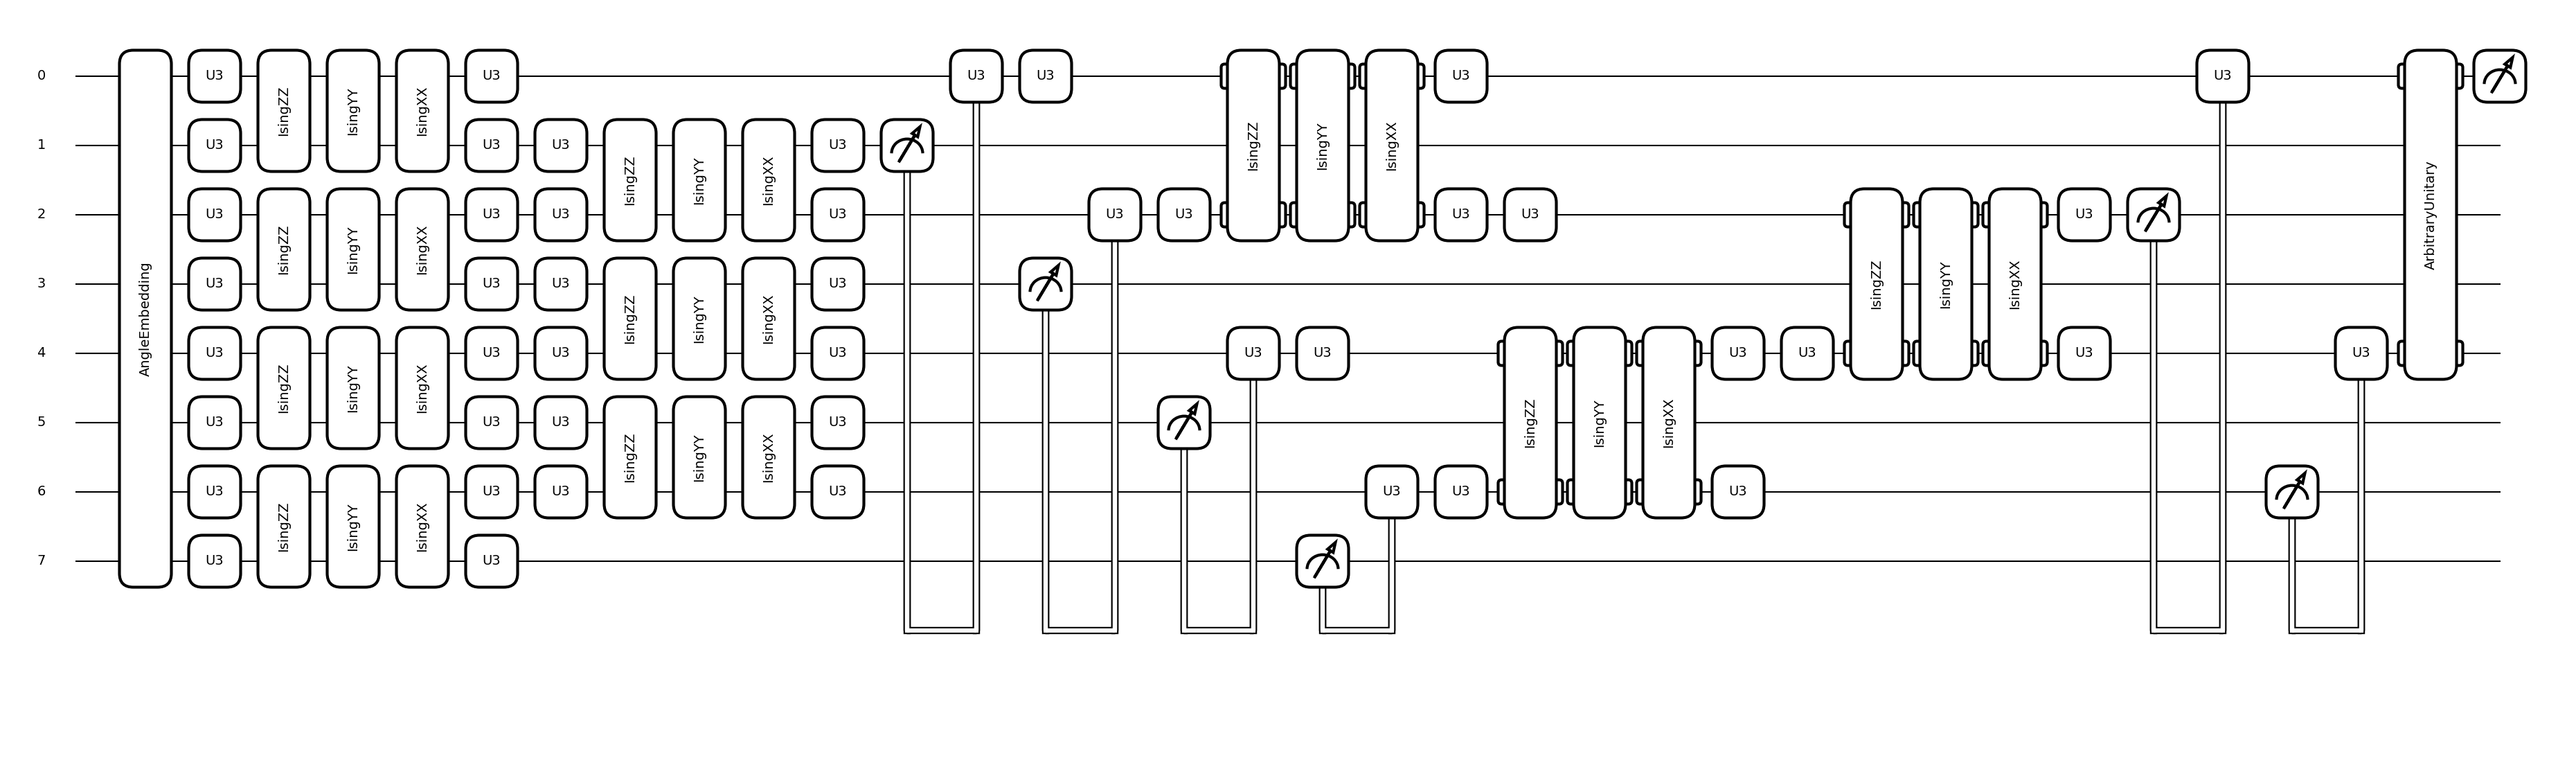

In [7]:
fig, ax = qml.draw_mpl(circuit)(conv_params, pool_params, last_params, classical_features)

In [53]:
n_qubits = 9
n_layers = 2
classical_features = np.random.rand(n_qubits)

In [58]:
# Quantum parameters
conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))
last_params = nn.Parameter(torch.randn(15))

# Quantum device initialization
dev = qml.device("default.qubit", wires=n_qubits)

def circuit(conv_weights, pool_weights, last_weights, features):
    wires = list(range(n_qubits))
    # Variational Embedding (Angle Embedding)
    qml.AngleEmbedding(features, wires=wires, rotation='Y')
    for layer in range(n_layers):
        # Convolutional Layer
        _apply_convolution(conv_weights[layer], wires)
        # Pooling Layer
        _apply_pooling(pool_weights[layer], wires)
        wires = wires[::2]  # Retain every second qubit after pooling
    # Apply an arbitrary unitary gate to a specified set of wires.
    qml.ArbitraryUnitary(last_weights, wires=[0,4])
    # Measurement: A single PauliZ to measure the state of the first qubit for binary classification
    return qml.expval(qml.PauliZ(0))

def _apply_convolution(weights, wires):
    """
    --- (2) MODIFICATION: Convolutional layer with global entanglement ---
    Applies a layer with specified non-adjacent entangling gates.
    """
    # Define the global entanglement pairs.
    # Note: The requested pair (7, 9) was adjusted to (6, 8)
    # as the circuit has 9 qubits (indexed 0-8).
    entanglement_pairs = [(0, 2), (3, 5), (6, 8)]
    processed_qubits = set()

    # Apply entangling blocks to specified pairs
    for q1, q2 in entanglement_pairs:
        # Check if both qubits are available in the current list of wires
        if q1 in wires and q2 in wires:
            # Apply the Quanvolution filter structure to the non-adjacent pair
            qml.U3(*weights[q1, :3], wires=q1)
            qml.U3(*weights[q2, 3:6], wires=q2)
            qml.IsingZZ(weights[q1, 6], wires=[q1, q2])
            qml.IsingYY(weights[q1, 7], wires=[q1, q2])
            qml.IsingXX(weights[q1, 8], wires=[q1, q2])
            qml.U3(*weights[q1, 9:12], wires=q1)
            qml.U3(*weights[q2, 12:], wires=q2)
            processed_qubits.add(q1)
            processed_qubits.add(q2)

    # Apply single-qubit gates to any remaining qubits
    for w in wires:
        if w not in processed_qubits:
            # Apply a sequence of 5 U3 gates to use all 15 parameters
            for i in range(5):
                qml.U3(*weights[w, i*3:(i+1)*3], wires=w)

def _apply_pooling(pool_weights, wires):
    # Pooling using a variational circuit
    n_wires = len(wires)
    assert n_wires >= 2, "Need at least two wires for pooling."
    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            measurement = qml.measure(w)
            qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

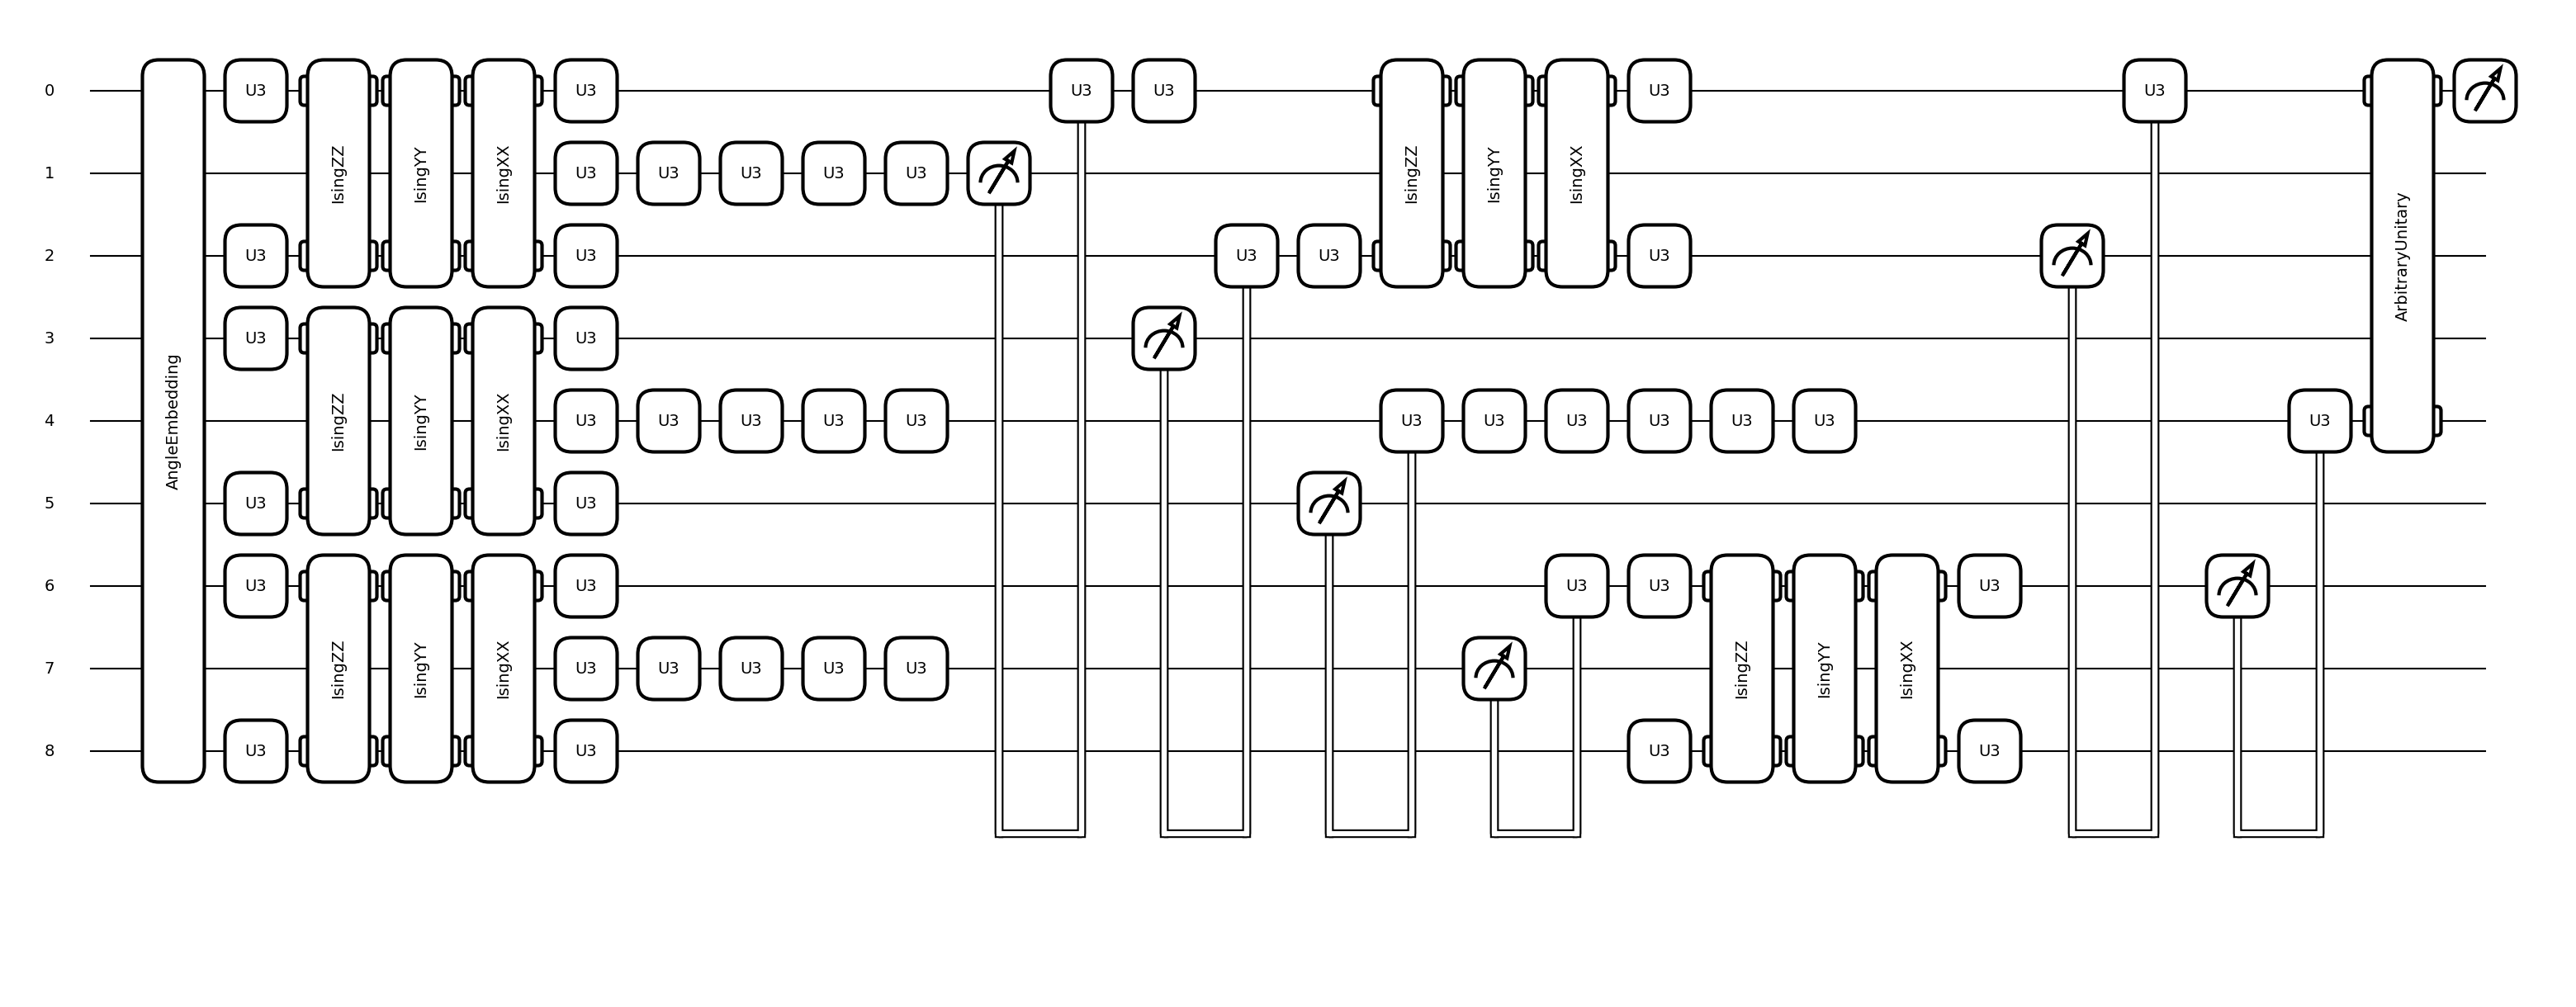

In [59]:
fig, ax = qml.draw_mpl(circuit)(conv_params, pool_params, last_params, classical_features)

/global/homes/j/junghoon/.local/perlmutter/python-3.11/lib/python3.11/site-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Total number of trainable parameters: 171
Circuit output: 0.2119514381344637

Generating circuit diagram...


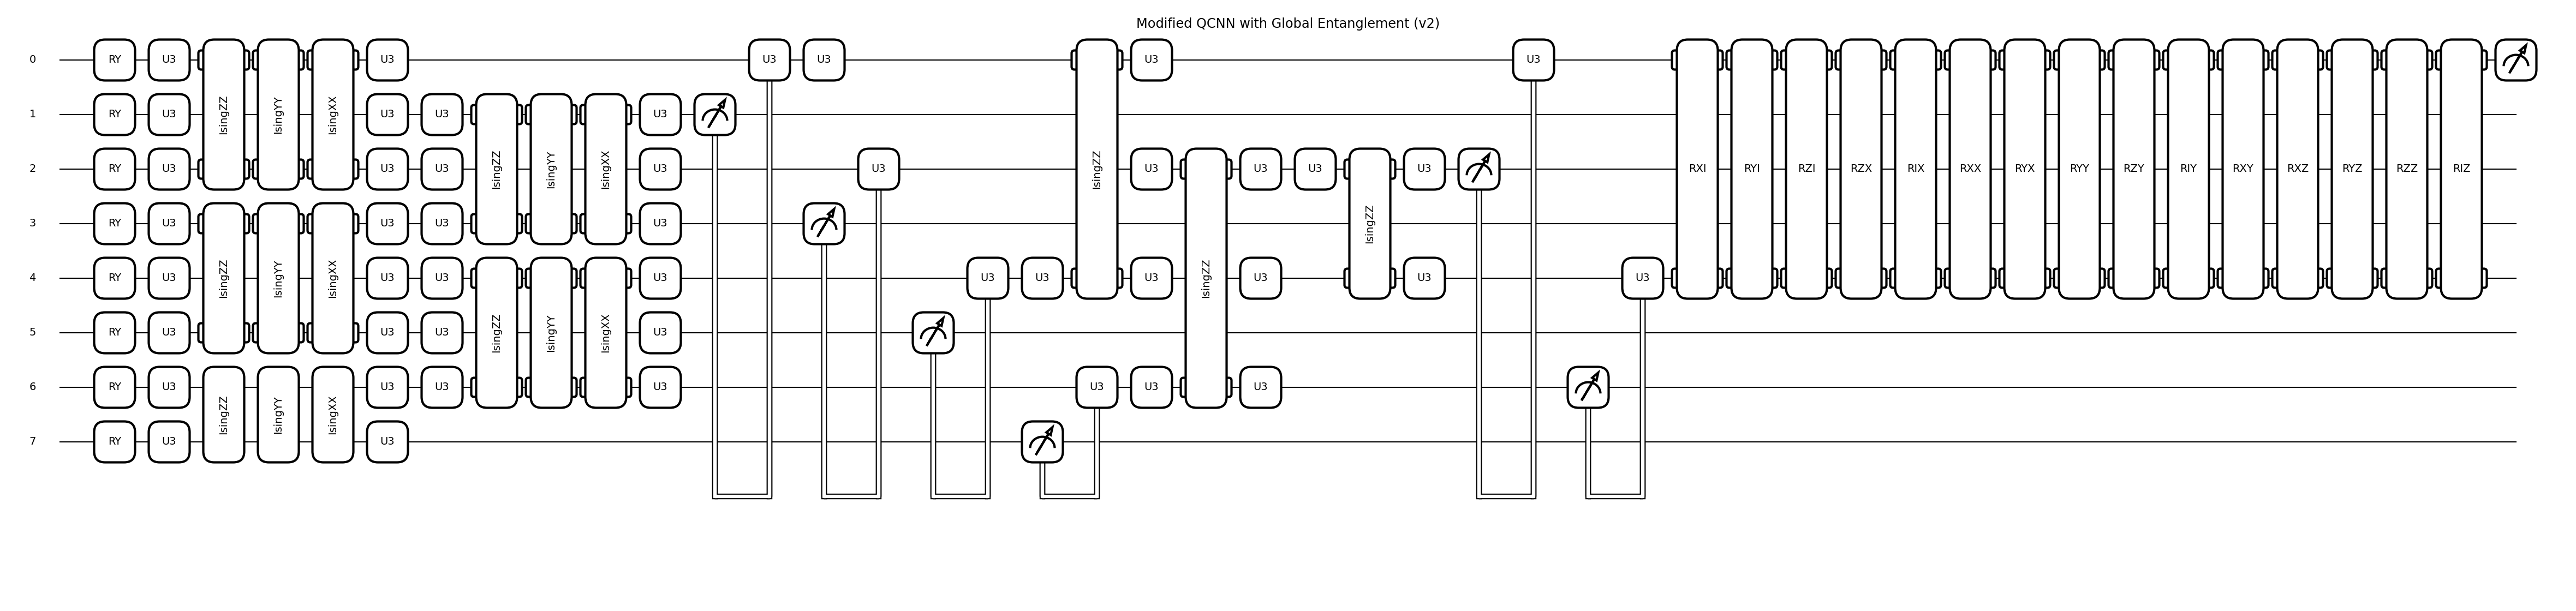

In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# --- 1. Define Circuit Parameters & Device ---
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

# The total number of parameters is updated for the new architecture:
# Layer 1 (U3-Ising-U3): (8*3) + (3*3) + (8*3) = 57
# Layer 2 (U3-Ising-U3): (6*3) + (2*3) + (6*3) = 42
# Pooling 1 (4 C-U3s): 4*3 = 12
# Layer 3 (Modified structure): 39 (see details in the circuit code)
# Pooling 2 (2 C-U3s): 2*3 = 6
# Final Unitary (2-qubit): 15
# TOTAL = 171 parameters
params = nn.Parameter(torch.randn(171))

# --- 2. Define the Modified Quantum Circuit ---

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def modified_qcnn_circuit(weights, features):
    """
    Quantum circuit with a specific, deep entanglement structure.
    """
    param_idx = 0

    # --- Initial State Preparation ---
    qml.AngleEmbedding(features, wires=range(n_qubits), rotation='Y')

    # --- Layer 1 (Unchanged) ---
    for i in range(n_qubits):
        qml.U3(*weights[param_idx : param_idx + 3], wires=i); param_idx += 3
    ising_pairs_1 = [(0, 2), (3, 5), (6, 7)]
    for p in ising_pairs_1:
        qml.IsingZZ(weights[param_idx], wires=p); param_idx += 1
        qml.IsingYY(weights[param_idx], wires=p); param_idx += 1
        qml.IsingXX(weights[param_idx], wires=p); param_idx += 1
    for i in range(n_qubits):
        qml.U3(*weights[param_idx : param_idx + 3], wires=i); param_idx += 3

    # --- Layer 2 (Unchanged) ---
    qubits_layer_2 = range(1, 7)
    for i in qubits_layer_2:
        qml.U3(*weights[param_idx : param_idx + 3], wires=i); param_idx += 3
    ising_pairs_2 = [(1, 3), (4, 6)]
    for p in ising_pairs_2:
        qml.IsingZZ(weights[param_idx], wires=p); param_idx += 1
        qml.IsingYY(weights[param_idx], wires=p); param_idx += 1
        qml.IsingXX(weights[param_idx], wires=p); param_idx += 1
    for i in qubits_layer_2:
        qml.U3(*weights[param_idx : param_idx + 3], wires=i); param_idx += 3

    # --- First Pooling Layer (Unchanged) ---
    pool_connections_1 = [(1, 0), (3, 2), (5, 4), (7, 6)]
    for measure_wire, target_wire in pool_connections_1:
        m_outcome = qml.measure(measure_wire)
        qml.cond(m_outcome, qml.U3)(*weights[param_idx : param_idx + 3], wires=target_wire)
        param_idx += 3

    # --- Layer 3 (MODIFIED AS PER REQUEST) ---
    active_qubits_1 = [0, 2, 4, 6]
    ising_pairs_3 = [(0, 4), (2, 6), (2, 4)]

    # (i) U3 gates before Ising layer, excluding qubit #2
    for i in [0, 4, 6]:
        qml.U3(*weights[param_idx : param_idx + 3], wires=i); param_idx += 3

    # First IsingZZ gate
    qml.IsingZZ(weights[param_idx], wires=ising_pairs_3[0]); param_idx += 1

    # (i, ii) U3 gates placed after the first IsingZZ
    qml.U3(*weights[param_idx : param_idx + 3], wires=2); param_idx += 3
    qml.U3(*weights[param_idx : param_idx + 3], wires=4); param_idx += 3

    # Second IsingZZ gate
    qml.IsingZZ(weights[param_idx], wires=ising_pairs_3[1]); param_idx += 1

    # (iii) U3 gates placed after the second IsingZZ
    qml.U3(*weights[param_idx : param_idx + 3], wires=2); param_idx += 3
    qml.U3(*weights[param_idx : param_idx + 3], wires=2); param_idx += 3
    qml.U3(*weights[param_idx : param_idx + 3], wires=4); param_idx += 3

    # Third IsingZZ gate
    qml.IsingZZ(weights[param_idx], wires=ising_pairs_3[2]); param_idx += 1

    # Original final U3 gates for the layer
    for i in active_qubits_1:
        qml.U3(*weights[param_idx : param_idx + 3], wires=i); param_idx += 3
        
    # --- Second Pooling Layer (Unchanged) ---
    pool_connections_2 = [(2, 0), (6, 4)]
    for measure_wire, target_wire in pool_connections_2:
        m_outcome = qml.measure(measure_wire)
        qml.cond(m_outcome, qml.U3)(*weights[param_idx : param_idx + 3], wires=target_wire)
        param_idx += 3

    # --- Final Operations (Unchanged) ---
    final_qubits = [0, 4]
    qml.ArbitraryUnitary(weights[param_idx : param_idx + 15], wires=final_qubits)
    param_idx += 15
    return qml.expval(qml.PauliZ(0))

# --- 3. Example Execution and Visualization ---

# Create dummy classical data
classical_features = np.random.rand(n_qubits)

# Execute the circuit
result = modified_qcnn_circuit(params, classical_features)

print(f"Total number of trainable parameters: {len(params)}")
print(f"Circuit output: {result.item()}")

# Visualize the circuit to verify its structure
print("\nGenerating circuit diagram...")
fig, ax = qml.draw_mpl(modified_qcnn_circuit)(params, classical_features)
fig.suptitle("Modified QCNN with Global Entanglement (v2)", fontsize="xx-large")

output_filename = "Quantum_Dilated_CNN.pdf"
plt.savefig(output_filename)

# fig.set_size_inches(24, 16)
plt.show()